# Exercise 9.1B: Observable Features in Encrypted Traffic

**Course**: SS*/AIML* ZG567 - AI and ML Techniques in Cyber Security  
**Module**: 09 - Network Traffic Profiling and Classification  
**Type**: Exploratory Analysis  
**Duration**: 2 hours  
**Difficulty**: Beginner-Intermediate

---

## 🎯 Scenario

Your SOC manager has challenged you to demonstrate that **encrypted traffic analysis is feasible without decryption**. Using packet captures from your network, you must identify what features remain observable in TLS 1.3 traffic and explain their security value.

## 📋 Learning Objectives

- Identify observable features in TLS-encrypted traffic
- Understand the security intelligence value of network metadata
- Recognize application-specific traffic patterns
- Articulate the feasibility of encrypted traffic analysis

---

**NIST Mapping**: DETECT → Security Continuous Monitoring (DE.CM-1: Network monitoring)  
**MITRE ATT&CK**: T1573 - Encrypted Channel

## Setup: Import Required Libraries

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
import hashlib
import struct

# Network analysis (optional - install if available)
try:
    from scapy.all import *
    from scapy.layers.tls.all import *
    SCAPY_AVAILABLE = True
    print("✅ Scapy available for packet analysis")
except ImportError:
    SCAPY_AVAILABLE = False
    print("⚠️ Scapy not available - using simulated data")

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")

⚠️ Scapy not available - using simulated data
✅ Libraries imported successfully!


## Task 1: Packet Capture Analysis

### 1.1 Generate Simulated TLS 1.3 Encrypted Sessions

For this exercise, we'll simulate TLS 1.3 encrypted traffic metadata that represents what's observable WITHOUT decryption.

In [2]:
# Simulate TLS session metadata (what's visible without decryption)
np.random.seed(42)

# Define application profiles with characteristic patterns
APPLICATION_PROFILES = {
    'web_browsing': {
        'packet_sizes': {'request': (100, 500), 'response': (1000, 1460)},
        'timing_pattern': 'bursty',
        'typical_duration': (1, 30),  # seconds
        'bidirectional_ratio': (0.1, 0.3),  # client/server bytes
        'tls_version': 'TLS 1.3',
        'sni_pattern': 'legitimate_domain'
    },
    'video_streaming': {
        'packet_sizes': {'request': (50, 200), 'response': (1400, 1460)},
        'timing_pattern': 'continuous',
        'typical_duration': (60, 3600),
        'bidirectional_ratio': (0.01, 0.05),
        'tls_version': 'TLS 1.3',
        'sni_pattern': 'cdn_domain'
    },
    'voip': {
        'packet_sizes': {'request': (100, 300), 'response': (100, 300)},
        'timing_pattern': 'periodic',
        'typical_duration': (30, 1800),
        'bidirectional_ratio': (0.8, 1.2),  # nearly symmetric
        'tls_version': 'TLS 1.3',
        'sni_pattern': 'voip_domain'
    },
    'file_upload': {
        'packet_sizes': {'request': (1400, 1460), 'response': (50, 200)},
        'timing_pattern': 'bursty',
        'typical_duration': (5, 300),
        'bidirectional_ratio': (5, 20),  # client sends more
        'tls_version': 'TLS 1.3',
        'sni_pattern': 'cloud_storage'
    },
    'malware_c2': {
        'packet_sizes': {'request': (50, 200), 'response': (50, 500)},
        'timing_pattern': 'beaconing',
        'typical_duration': (60, 3600),
        'bidirectional_ratio': (0.5, 2.0),
        'tls_version': 'TLS 1.2',  # Often older TLS
        'sni_pattern': 'suspicious_domain'
    }
}

def generate_packet_sequence(app_type, num_packets=50):
    """Generate packet size sequence for an application type."""
    profile = APPLICATION_PROFILES[app_type]
    packets = []
    
    for i in range(num_packets):
        # Alternate between client and server packets
        if i % 2 == 0:  # Client packet
            size = np.random.randint(*profile['packet_sizes']['request'])
            direction = 'outbound'
        else:  # Server packet
            size = np.random.randint(*profile['packet_sizes']['response'])
            direction = 'inbound'
        
        packets.append({'size': size, 'direction': direction})
    
    return packets

def generate_flow_metadata(app_type, flow_id):
    """Generate complete flow metadata for an application."""
    profile = APPLICATION_PROFILES[app_type]
    
    # Generate packet sequence
    num_packets = np.random.randint(20, 100)
    packets = generate_packet_sequence(app_type, num_packets)
    
    # Calculate flow statistics
    outbound_sizes = [p['size'] for p in packets if p['direction'] == 'outbound']
    inbound_sizes = [p['size'] for p in packets if p['direction'] == 'inbound']
    
    # Generate timing based on pattern
    if profile['timing_pattern'] == 'bursty':
        inter_arrival_times = np.concatenate([
            np.random.exponential(0.01, num_packets // 2),  # Burst
            np.random.exponential(1.0, num_packets // 2)    # Quiet
        ])
    elif profile['timing_pattern'] == 'continuous':
        inter_arrival_times = np.random.exponential(0.02, num_packets)
    elif profile['timing_pattern'] == 'periodic':
        inter_arrival_times = np.random.normal(0.02, 0.002, num_packets)
    else:  # beaconing
        beacon_interval = np.random.choice([30, 60, 120, 300])
        inter_arrival_times = np.random.normal(beacon_interval, beacon_interval * 0.1, num_packets)
    
    duration = np.random.uniform(*profile['typical_duration'])
    
    return {
        'flow_id': flow_id,
        'application': app_type,
        'tls_version': profile['tls_version'],
        'duration_sec': duration,
        'total_packets': num_packets,
        'outbound_packets': len(outbound_sizes),
        'inbound_packets': len(inbound_sizes),
        'total_bytes': sum(outbound_sizes) + sum(inbound_sizes),
        'outbound_bytes': sum(outbound_sizes),
        'inbound_bytes': sum(inbound_sizes),
        'avg_packet_size': np.mean(outbound_sizes + inbound_sizes),
        'std_packet_size': np.std(outbound_sizes + inbound_sizes),
        'min_packet_size': min(outbound_sizes + inbound_sizes),
        'max_packet_size': max(outbound_sizes + inbound_sizes),
        'avg_iat': np.mean(inter_arrival_times),
        'std_iat': np.std(inter_arrival_times),
        'bidirectional_ratio': sum(outbound_sizes) / max(sum(inbound_sizes), 1),
        'packet_size_sequence': [p['size'] for p in packets[:10]],  # First 10 packets
        'timing_pattern': profile['timing_pattern']
    }

# Generate dataset
flows = []
for i, app_type in enumerate(APPLICATION_PROFILES.keys()):
    for j in range(100):  # 100 flows per application
        flow = generate_flow_metadata(app_type, f"{app_type}_{j}")
        flows.append(flow)

df = pd.DataFrame(flows)

print(f"✅ Generated {len(df):,} encrypted traffic flows")
print(f"📊 Application types: {df['application'].nunique()}")
print(f"\nFlows per application:")
print(df['application'].value_counts())

✅ Generated 500 encrypted traffic flows
📊 Application types: 5

Flows per application:
application
web_browsing       100
video_streaming    100
voip               100
file_upload        100
malware_c2         100
Name: count, dtype: int64


### 1.2 Explore Observable Features

Document what features are visible in TLS 1.3 encrypted traffic.

In [3]:
# Display observable features in encrypted traffic
print("=" * 80)
print("OBSERVABLE FEATURES IN TLS 1.3 ENCRYPTED TRAFFIC")
print("=" * 80)

observable_features = {
    'TLS Handshake Metadata': [
        ('TLS Version', 'Visible', 'Identifies client/server capabilities'),
        ('Cipher Suites Offered', 'Visible', 'Client fingerprinting (JA3)'),
        ('Extensions', 'Visible', 'TLS extensions reveal client type'),
        ('SNI (Server Name Indication)', 'Visible in TLS 1.2, encrypted in ECH', 'Destination domain'),
        ('Certificate', 'Visible', 'Server identity verification'),
        ('Session ID/Ticket', 'Visible', 'Session resumption detection'),
    ],
    'Flow Statistics': [
        ('Packet Count', 'Visible', 'Connection volume'),
        ('Byte Count', 'Visible', 'Data volume'),
        ('Flow Duration', 'Visible', 'Connection lifetime'),
        ('Bidirectional Ratio', 'Visible', 'Upload vs download patterns'),
    ],
    'Packet-Level Features': [
        ('Packet Sizes', 'Visible', 'Application fingerprinting'),
        ('Inter-Arrival Times', 'Visible', 'Timing patterns, beaconing'),
        ('TCP Flags', 'Visible', 'Connection state'),
        ('Sequence Numbers', 'Visible', 'Retransmission detection'),
    ],
    'Network Topology': [
        ('Source/Dest IP', 'Visible', 'Network location'),
        ('Source/Dest Port', 'Visible', 'Service identification'),
        ('IP TTL', 'Visible', 'Network path estimation'),
        ('IP Flags', 'Visible', 'Fragmentation detection'),
    ],
    'Hidden (Encrypted)': [
        ('HTTP Headers', 'Encrypted', 'User-Agent, Cookies, etc.'),
        ('Payload Data', 'Encrypted', 'Application content'),
        ('URLs/Paths', 'Encrypted', 'Specific resources requested'),
        ('Authentication Data', 'Encrypted', 'Credentials, tokens'),
    ]
}

for category, features in observable_features.items():
    print(f"\n📁 {category}")
    print("-" * 70)
    for feature, visibility, security_value in features:
        icon = '✅' if visibility == 'Visible' else '🔒'
        print(f"   {icon} {feature:30s} | {visibility:15s} | {security_value}")

OBSERVABLE FEATURES IN TLS 1.3 ENCRYPTED TRAFFIC

📁 TLS Handshake Metadata
----------------------------------------------------------------------
   ✅ TLS Version                    | Visible         | Identifies client/server capabilities
   ✅ Cipher Suites Offered          | Visible         | Client fingerprinting (JA3)
   ✅ Extensions                     | Visible         | TLS extensions reveal client type
   🔒 SNI (Server Name Indication)   | Visible in TLS 1.2, encrypted in ECH | Destination domain
   ✅ Certificate                    | Visible         | Server identity verification
   ✅ Session ID/Ticket              | Visible         | Session resumption detection

📁 Flow Statistics
----------------------------------------------------------------------
   ✅ Packet Count                   | Visible         | Connection volume
   ✅ Byte Count                     | Visible         | Data volume
   ✅ Flow Duration                  | Visible         | Connection lifetime
   ✅ Bidirec

### 1.3 Calculate Flow Statistics

Extract and analyze statistical features from encrypted flows.

In [4]:
# Display dataset overview
print("=" * 80)
print("ENCRYPTED FLOW DATASET OVERVIEW")
print("=" * 80)

display(df.head(10))

# Statistical summary
print("\n" + "=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)

numeric_cols = ['duration_sec', 'total_packets', 'total_bytes', 'avg_packet_size', 
                'std_packet_size', 'avg_iat', 'bidirectional_ratio']

display(df[numeric_cols].describe())

ENCRYPTED FLOW DATASET OVERVIEW


,flow_id,application,tls_version,duration_sec,total_packets,outbound_packets,inbound_packets,total_bytes,outbound_bytes,inbound_bytes,avg_packet_size,std_packet_size,min_packet_size,max_packet_size,avg_iat,std_iat,bidirectional_ratio,packet_size_sequence,timing_pattern
0,web_browsing_0,web_browsing,TLS 1.3,26.272357,71,36,35,54275,10683,43592,764.436620,490.182942,120,1445,0.426098,0.644497,0.245068,"[448, 1270, 206, 1071, 288, 1020, 202, 1121, 3...",bursty
1,web_browsing_1,web_browsing,TLS 1.3,26.596454,47,24,23,35956,7705,28251,765.021277,465.491481,151,1445,0.655101,1.163581,0.272734,"[207, 1043, 439, 1285, 430, 1127, 447, 1230, 2...",bursty
2,web_browsing_2,web_browsing,TLS 1.3,28.273299,28,14,14,21134,4130,17004,754.785714,472.134466,203,1455,0.512384,0.823910,0.242884,"[332, 1098, 246, 1303, 307, 1130, 251, 1053, 2...",bursty
3,web_browsing_3,web_browsing,TLS 1.3,26.713731,65,33,32,49556,10307,39249,762.400000,473.631106,112,1459,0.431632,0.791219,0.262605,"[472, 1005, 198, 1379, 332, 1036, 379, 1348, 4...",bursty
4,web_browsing_4,web_browsing,TLS 1.3,12.606464,71,36,35,54166,11018,43148,762.901408,479.334520,111,1426,0.545150,0.764123,0.255354,"[322, 1393, 349, 1146, 195, 1256, 424, 1003, 1...",bursty
5,web_browsing_5,web_browsing,TLS 1.3,8.173095,44,22,22,33099,5737,27362,752.250000,505.778344,100,1459,0.947760,1.680112,0.209670,"[411, 1416, 216, 1133, 157, 1043, 272, 1159, 2...",bursty
6,web_browsing_6,web_browsing,TLS 1.3,6.785701,97,49,48,75406,15013,60393,777.381443,490.665621,107,1458,0.563688,0.960819,0.248588,"[465, 1000, 150, 1172, 304, 1259, 468, 1287, 1...",bursty
7,web_browsing_7,web_browsing,TLS 1.3,22.185925,39,20,19,29537,6135,23402,757.358974,481.716881,137,1458,0.425704,0.586900,0.262157,"[212, 1139, 146, 1000, 189, 1141, 419, 1037, 3...",bursty
8,web_browsing_8,web_browsing,TLS 1.3,9.988171,61,31,30,45878,9344,36534,752.098361,473.643835,104,1419,0.475524,0.794994,0.255762,"[114, 1110, 256, 1288, 330, 1410, 256, 1037, 1...",bursty
9,web_browsing_9,web_browsing,TLS 1.3,21.924453,70,35,35,54249,11339,42910,774.985714,467.241403,118,1457,0.468958,0.705144,0.264251,"[478, 1439, 310, 1317, 131, 1157, 384, 1304, 3...",bursty



STATISTICAL SUMMARY


,duration_sec,total_packets,total_bytes,avg_packet_size,std_packet_size,avg_iat,bidirectional_ratio
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,927.669151,59.554000,32059.382000,541.994073,392.902795,23.423974,2.752920
std,1028.264203,22.041932,21107.411414,280.232277,257.435853,65.274617,4.639980
min,1.422447,20.000000,3748.000000,152.320000,45.580039,0.012231,0.072100
25%,69.359059,41.000000,14649.500000,203.284591,113.610955,0.020168,0.233936
50%,398.505608,61.000000,26562.500000,753.663189,480.386339,0.432089,0.458131
75%,1566.804278,78.000000,50646.000000,775.611702,651.768585,0.604474,1.072373
max,3594.903280,99.000000,77908.000000,806.714286,670.972452,311.997794,18.919180


## Task 2: Feature Categorization

### 2.1 Create Feature-Visibility-Security Value Table

In [5]:
# Create comprehensive feature categorization table
feature_table = pd.DataFrame([
    # TLS Metadata Features
    {'Category': 'TLS Metadata', 'Feature': 'TLS Version', 'Visibility': 'Full', 
     'Security Value': 'High', 'Use Case': 'Detect outdated/vulnerable clients'},
    {'Category': 'TLS Metadata', 'Feature': 'Cipher Suites', 'Visibility': 'Full', 
     'Security Value': 'High', 'Use Case': 'JA3/JA4+ fingerprinting for client ID'},
    {'Category': 'TLS Metadata', 'Feature': 'Extensions Count', 'Visibility': 'Full', 
     'Security Value': 'Medium', 'Use Case': 'Anomaly detection in handshake'},
    {'Category': 'TLS Metadata', 'Feature': 'SNI (Server Name)', 'Visibility': 'Partial', 
     'Security Value': 'Critical', 'Use Case': 'Domain reputation, threat intel'},
    {'Category': 'TLS Metadata', 'Feature': 'Certificate Chain', 'Visibility': 'Full', 
     'Security Value': 'High', 'Use Case': 'Certificate validation, issuer analysis'},
    
    # Flow Statistics
    {'Category': 'Flow Statistics', 'Feature': 'Total Packets', 'Visibility': 'Full', 
     'Security Value': 'Medium', 'Use Case': 'Connection volume analysis'},
    {'Category': 'Flow Statistics', 'Feature': 'Total Bytes', 'Visibility': 'Full', 
     'Security Value': 'High', 'Use Case': 'Data exfiltration detection'},
    {'Category': 'Flow Statistics', 'Feature': 'Flow Duration', 'Visibility': 'Full', 
     'Security Value': 'Medium', 'Use Case': 'Long-lived C2 connections'},
    {'Category': 'Flow Statistics', 'Feature': 'Bytes/Packet Ratio', 'Visibility': 'Full', 
     'Security Value': 'Medium', 'Use Case': 'Protocol identification'},
    {'Category': 'Flow Statistics', 'Feature': 'Upload/Download Ratio', 'Visibility': 'Full', 
     'Security Value': 'High', 'Use Case': 'Exfiltration vs download pattern'},
    
    # Timing Features
    {'Category': 'Timing Patterns', 'Feature': 'Inter-Arrival Time Mean', 'Visibility': 'Full', 
     'Security Value': 'Critical', 'Use Case': 'Beaconing detection'},
    {'Category': 'Timing Patterns', 'Feature': 'Inter-Arrival Time Std', 'Visibility': 'Full', 
     'Security Value': 'High', 'Use Case': 'Regular vs bursty traffic'},
    {'Category': 'Timing Patterns', 'Feature': 'Periodicity', 'Visibility': 'Full', 
     'Security Value': 'Critical', 'Use Case': 'C2 beacon interval detection'},
    
    # Packet Size Features
    {'Category': 'Packet Size', 'Feature': 'Avg Packet Size', 'Visibility': 'Full', 
     'Security Value': 'High', 'Use Case': 'Application fingerprinting'},
    {'Category': 'Packet Size', 'Feature': 'Packet Size Variance', 'Visibility': 'Full', 
     'Security Value': 'Medium', 'Use Case': 'Streaming vs interactive traffic'},
    {'Category': 'Packet Size', 'Feature': 'First N Packet Sizes', 'Visibility': 'Full', 
     'Security Value': 'High', 'Use Case': 'Application identification (PSS)'},
    {'Category': 'Packet Size', 'Feature': 'Max Packet Size', 'Visibility': 'Full', 
     'Security Value': 'Medium', 'Use Case': 'MTU/fragmentation analysis'},
    
    # Network Topology
    {'Category': 'Network Topology', 'Feature': 'Source/Dest IP', 'Visibility': 'Full', 
     'Security Value': 'Critical', 'Use Case': 'Threat intel, geo-blocking'},
    {'Category': 'Network Topology', 'Feature': 'Dest Port', 'Visibility': 'Full', 
     'Security Value': 'Medium', 'Use Case': 'Non-standard port detection'},
    {'Category': 'Network Topology', 'Feature': 'Connection Count', 'Visibility': 'Full', 
     'Security Value': 'High', 'Use Case': 'Lateral movement, scanning'},
])

print("=" * 100)
print("FEATURE CATEGORIZATION TABLE (20+ Observable Features)")
print("=" * 100)
display(feature_table)

# Summary statistics
print(f"\n✅ Total Observable Features: {len(feature_table)}")
print(f"\n📊 Security Value Distribution:")
print(feature_table['Security Value'].value_counts())

FEATURE CATEGORIZATION TABLE (20+ Observable Features)


,Category,Feature,Visibility,Security Value,Use Case
0,TLS Metadata,TLS Version,Full,High,Detect outdated/vulnerable clients
1,TLS Metadata,Cipher Suites,Full,High,JA3/JA4+ fingerprinting for client ID
2,TLS Metadata,Extensions Count,Full,Medium,Anomaly detection in handshake
3,TLS Metadata,SNI (Server Name),Partial,Critical,"Domain reputation, threat intel"
4,TLS Metadata,Certificate Chain,Full,High,"Certificate validation, issuer analysis"
5,Flow Statistics,Total Packets,Full,Medium,Connection volume analysis
6,Flow Statistics,Total Bytes,Full,High,Data exfiltration detection
7,Flow Statistics,Flow Duration,Full,Medium,Long-lived C2 connections
8,Flow Statistics,Bytes/Packet Ratio,Full,Medium,Protocol identification
9,Flow Statistics,Upload/Download Ratio,Full,High,Exfiltration vs download pattern



✅ Total Observable Features: 20

📊 Security Value Distribution:
Security Value
High        9
Medium      7
Critical    4
Name: count, dtype: int64


### 2.2 Explain Security Intelligence Value of Each Feature Category

In [6]:
# Security intelligence value explanation
print("=" * 80)
print("SECURITY INTELLIGENCE VALUE BY FEATURE CATEGORY")
print("=" * 80)

security_explanations = {
    'TLS Metadata': {
        'description': 'TLS handshake parameters that identify client/server capabilities',
        'security_value': [
            'JA3/JA4+ fingerprinting uniquely identifies malware families',
            'Outdated TLS versions indicate vulnerable or suspicious clients',
            'Certificate analysis detects self-signed or suspicious issuers',
            'SNI enables domain reputation checking without decryption'
        ],
        'detection_examples': ['Cobalt Strike beacon', 'Emotet C2', 'Trickbot loader']
    },
    'Flow Statistics': {
        'description': 'Aggregate statistics about connection volume and duration',
        'security_value': [
            'Data exfiltration shows abnormal upload volumes',
            'Long-lived connections may indicate persistent C2',
            'Unusual byte counts reveal tunneling or encoding',
            'Bidirectional ratios distinguish app types'
        ],
        'detection_examples': ['Data staging', 'DNS tunneling', 'Encrypted RAT']
    },
    'Timing Patterns': {
        'description': 'Inter-arrival times and periodicity of packets',
        'security_value': [
            'Beaconing detection: regular intervals indicate C2',
            'Jitter analysis reveals randomization attempts',
            'Burst patterns distinguish interactive vs automated',
            'Sleep timers encoded in timing'
        ],
        'detection_examples': ['Beacon interval detection', 'Ransomware callback', 'APT C2']
    },
    'Packet Size': {
        'description': 'Distribution and sequence of packet sizes',
        'security_value': [
            'Application fingerprinting: video vs web vs VoIP',
            'Packet Size Sequence (PSS) reveals protocol behavior',
            'Anomalous sizes indicate tunneling/encoding',
            'MTU analysis reveals VPN/proxy usage'
        ],
        'detection_examples': ['Tor traffic', 'VPN detection', 'Covert channels']
    },
    'Network Topology': {
        'description': 'Source/destination information and connection patterns',
        'security_value': [
            'Threat intelligence correlation on IPs',
            'Geo-anomaly detection (unusual destinations)',
            'Lateral movement via internal connections',
            'Non-standard ports for common protocols'
        ],
        'detection_examples': ['C2 IP blocklisting', 'Rare destination', 'Port hopping']
    }
}

for category, details in security_explanations.items():
    print(f"\n📌 {category.upper()}")
    print(f"   {details['description']}")
    print("\n   Security Value:")
    for value in details['security_value']:
        print(f"   • {value}")
    print(f"\n   Detection Examples: {', '.join(details['detection_examples'])}")
    print("-" * 80)

SECURITY INTELLIGENCE VALUE BY FEATURE CATEGORY

📌 TLS METADATA
   TLS handshake parameters that identify client/server capabilities

   Security Value:
   • JA3/JA4+ fingerprinting uniquely identifies malware families
   • Outdated TLS versions indicate vulnerable or suspicious clients
   • Certificate analysis detects self-signed or suspicious issuers
   • SNI enables domain reputation checking without decryption

   Detection Examples: Cobalt Strike beacon, Emotet C2, Trickbot loader
--------------------------------------------------------------------------------

📌 FLOW STATISTICS
   Aggregate statistics about connection volume and duration

   Security Value:
   • Data exfiltration shows abnormal upload volumes
   • Long-lived connections may indicate persistent C2
   • Unusual byte counts reveal tunneling or encoding
   • Bidirectional ratios distinguish app types

   Detection Examples: Data staging, DNS tunneling, Encrypted RAT
--------------------------------------------------

## Task 3: Application Fingerprinting Demo

### 3.1 Analyze Distinguishing Patterns for 5 Application Types

In [7]:
# Analyze patterns for each application type
print("=" * 80)
print("APPLICATION FINGERPRINTING ANALYSIS")
print("=" * 80)

for app_type in df['application'].unique():
    app_df = df[df['application'] == app_type]
    
    print(f"\n📱 {app_type.upper().replace('_', ' ')}")
    print("-" * 60)
    
    print(f"   📊 Statistics (n={len(app_df)} flows):")
    print(f"      Avg Duration:        {app_df['duration_sec'].mean():.1f} sec")
    print(f"      Avg Total Bytes:     {app_df['total_bytes'].mean():,.0f}")
    print(f"      Avg Packet Size:     {app_df['avg_packet_size'].mean():.1f}")
    print(f"      Packet Size Std:     {app_df['std_packet_size'].mean():.1f}")
    print(f"      Bidirectional Ratio: {app_df['bidirectional_ratio'].mean():.2f}")
    print(f"      Avg IAT:             {app_df['avg_iat'].mean():.4f} sec")
    print(f"      TLS Version:         {app_df['tls_version'].iloc[0]}")
    print(f"      Timing Pattern:      {app_df['timing_pattern'].iloc[0]}")
    
    # Key discriminative features
    print(f"\n   🔑 Key Discriminative Features:")
    if app_type == 'web_browsing':
        print("      • Bursty traffic with variable packet sizes")
        print("      • Small requests, large responses")
        print("      • Short to medium duration")
    elif app_type == 'video_streaming':
        print("      • Continuous large packets (near MTU)")
        print("      • Very low bidirectional ratio (mostly download)")
        print("      • Long duration, high byte count")
    elif app_type == 'voip':
        print("      • Symmetric bidirectional ratio (~1.0)")
        print("      • Periodic timing (codec-based)")
        print("      • Small, consistent packet sizes")
    elif app_type == 'file_upload':
        print("      • High bidirectional ratio (client sends more)")
        print("      • Large outbound packets, small acknowledgments")
        print("      • Bursty transfer pattern")
    elif app_type == 'malware_c2':
        print("      • 🚨 BEACONING pattern - regular intervals")
        print("      • Small, consistent packet sizes")
        print("      • Often uses older TLS versions")
        print("      • Low data volume, long duration")

APPLICATION FINGERPRINTING ANALYSIS

📱 WEB BROWSING
------------------------------------------------------------
   📊 Statistics (n=100 flows):
      Avg Duration:        15.4 sec
      Avg Total Bytes:     44,813
      Avg Packet Size:     756.6
      Packet Size Std:     479.4
      Bidirectional Ratio: 0.25
      Avg IAT:             0.5049 sec
      TLS Version:         TLS 1.3
      Timing Pattern:      bursty

   🔑 Key Discriminative Features:
      • Bursty traffic with variable packet sizes
      • Small requests, large responses
      • Short to medium duration

📱 VIDEO STREAMING
------------------------------------------------------------
   📊 Statistics (n=100 flows):
      Avg Duration:        1762.3 sec
      Avg Total Bytes:     45,286
      Avg Packet Size:     769.3
      Packet Size Std:     653.5
      Bidirectional Ratio: 0.09
      Avg IAT:             0.0199 sec
      TLS Version:         TLS 1.3
      Timing Pattern:      continuous

   🔑 Key Discriminative Featur

### 3.2 Visualize Packet Size Distributions by Application

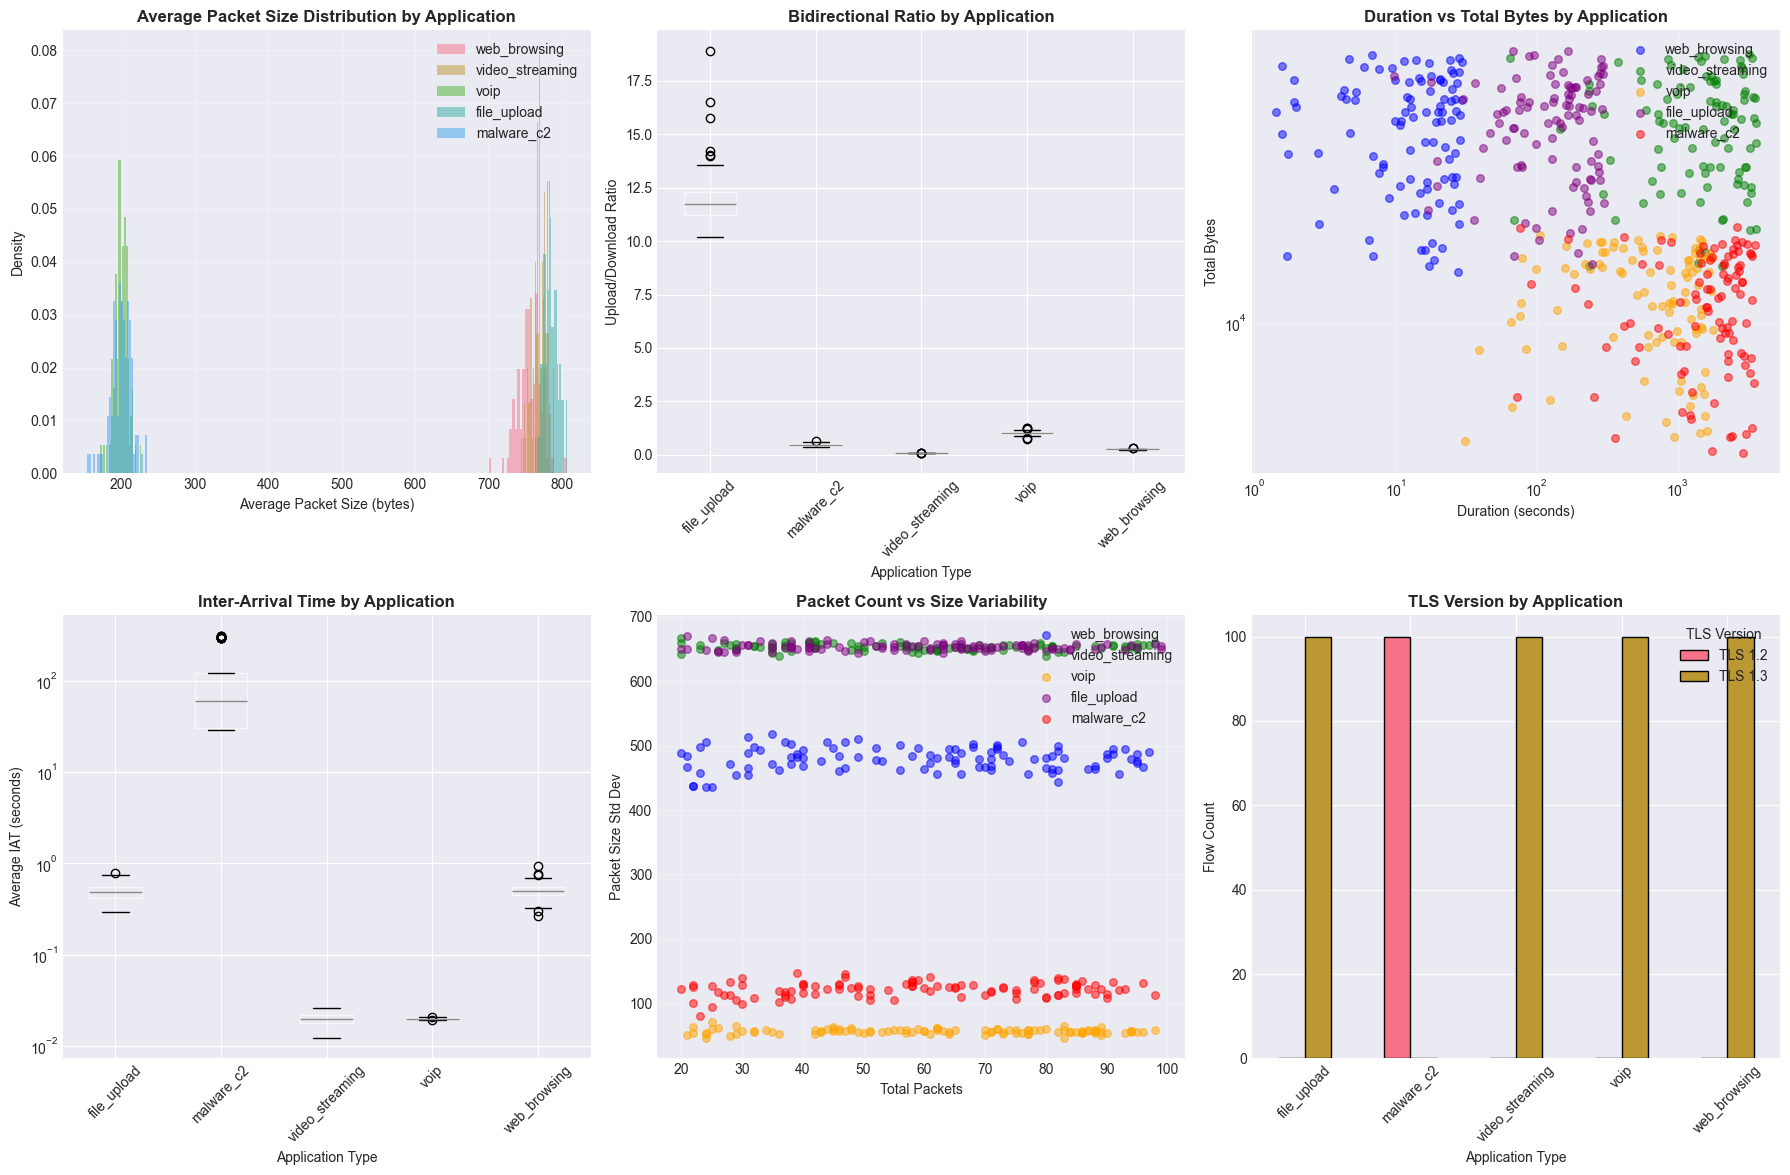

✅ Visualizations saved to 'application_fingerprinting.png'


In [8]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Packet Size Distribution by Application
ax1 = axes[0, 0]
for app_type in df['application'].unique():
    app_df = df[df['application'] == app_type]
    ax1.hist(app_df['avg_packet_size'], bins=30, alpha=0.5, label=app_type, density=True)
ax1.set_title('Average Packet Size Distribution by Application', fontsize=12, fontweight='bold')
ax1.set_xlabel('Average Packet Size (bytes)')
ax1.set_ylabel('Density')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)

# 2. Bidirectional Ratio Comparison
ax2 = axes[0, 1]
df.boxplot(column='bidirectional_ratio', by='application', ax=ax2)
ax2.set_title('Bidirectional Ratio by Application', fontsize=12, fontweight='bold')
ax2.set_xlabel('Application Type')
ax2.set_ylabel('Upload/Download Ratio')
plt.suptitle('')  # Remove automatic title
ax2.tick_params(axis='x', rotation=45)

# 3. Duration vs Total Bytes (colored by app)
ax3 = axes[0, 2]
colors = {'web_browsing': 'blue', 'video_streaming': 'green', 'voip': 'orange', 
          'file_upload': 'purple', 'malware_c2': 'red'}
for app_type in df['application'].unique():
    app_df = df[df['application'] == app_type]
    ax3.scatter(app_df['duration_sec'], app_df['total_bytes'], 
                alpha=0.5, label=app_type, c=colors[app_type], s=30)
ax3.set_title('Duration vs Total Bytes by Application', fontsize=12, fontweight='bold')
ax3.set_xlabel('Duration (seconds)')
ax3.set_ylabel('Total Bytes')
ax3.legend(loc='upper right')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.grid(alpha=0.3)

# 4. Inter-Arrival Time by Application
ax4 = axes[1, 0]
df.boxplot(column='avg_iat', by='application', ax=ax4)
ax4.set_title('Inter-Arrival Time by Application', fontsize=12, fontweight='bold')
ax4.set_xlabel('Application Type')
ax4.set_ylabel('Average IAT (seconds)')
plt.suptitle('')
ax4.tick_params(axis='x', rotation=45)
ax4.set_yscale('log')

# 5. Packet Count vs Packet Size Std
ax5 = axes[1, 1]
for app_type in df['application'].unique():
    app_df = df[df['application'] == app_type]
    ax5.scatter(app_df['total_packets'], app_df['std_packet_size'], 
                alpha=0.5, label=app_type, c=colors[app_type], s=30)
ax5.set_title('Packet Count vs Size Variability', fontsize=12, fontweight='bold')
ax5.set_xlabel('Total Packets')
ax5.set_ylabel('Packet Size Std Dev')
ax5.legend(loc='upper right')
ax5.grid(alpha=0.3)

# 6. TLS Version Distribution
ax6 = axes[1, 2]
tls_counts = df.groupby(['application', 'tls_version']).size().unstack(fill_value=0)
tls_counts.plot(kind='bar', ax=ax6, edgecolor='black')
ax6.set_title('TLS Version by Application', fontsize=12, fontweight='bold')
ax6.set_xlabel('Application Type')
ax6.set_ylabel('Flow Count')
ax6.tick_params(axis='x', rotation=45)
ax6.legend(title='TLS Version')

plt.tight_layout()
plt.savefig('application_fingerprinting.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved to 'application_fingerprinting.png'")

### 3.3 First 10 Packet Size Sequence Analysis (PSS)

PACKET SIZE SEQUENCE (PSS) ANALYSIS

The first 10 packet sizes reveal application behavior patterns:


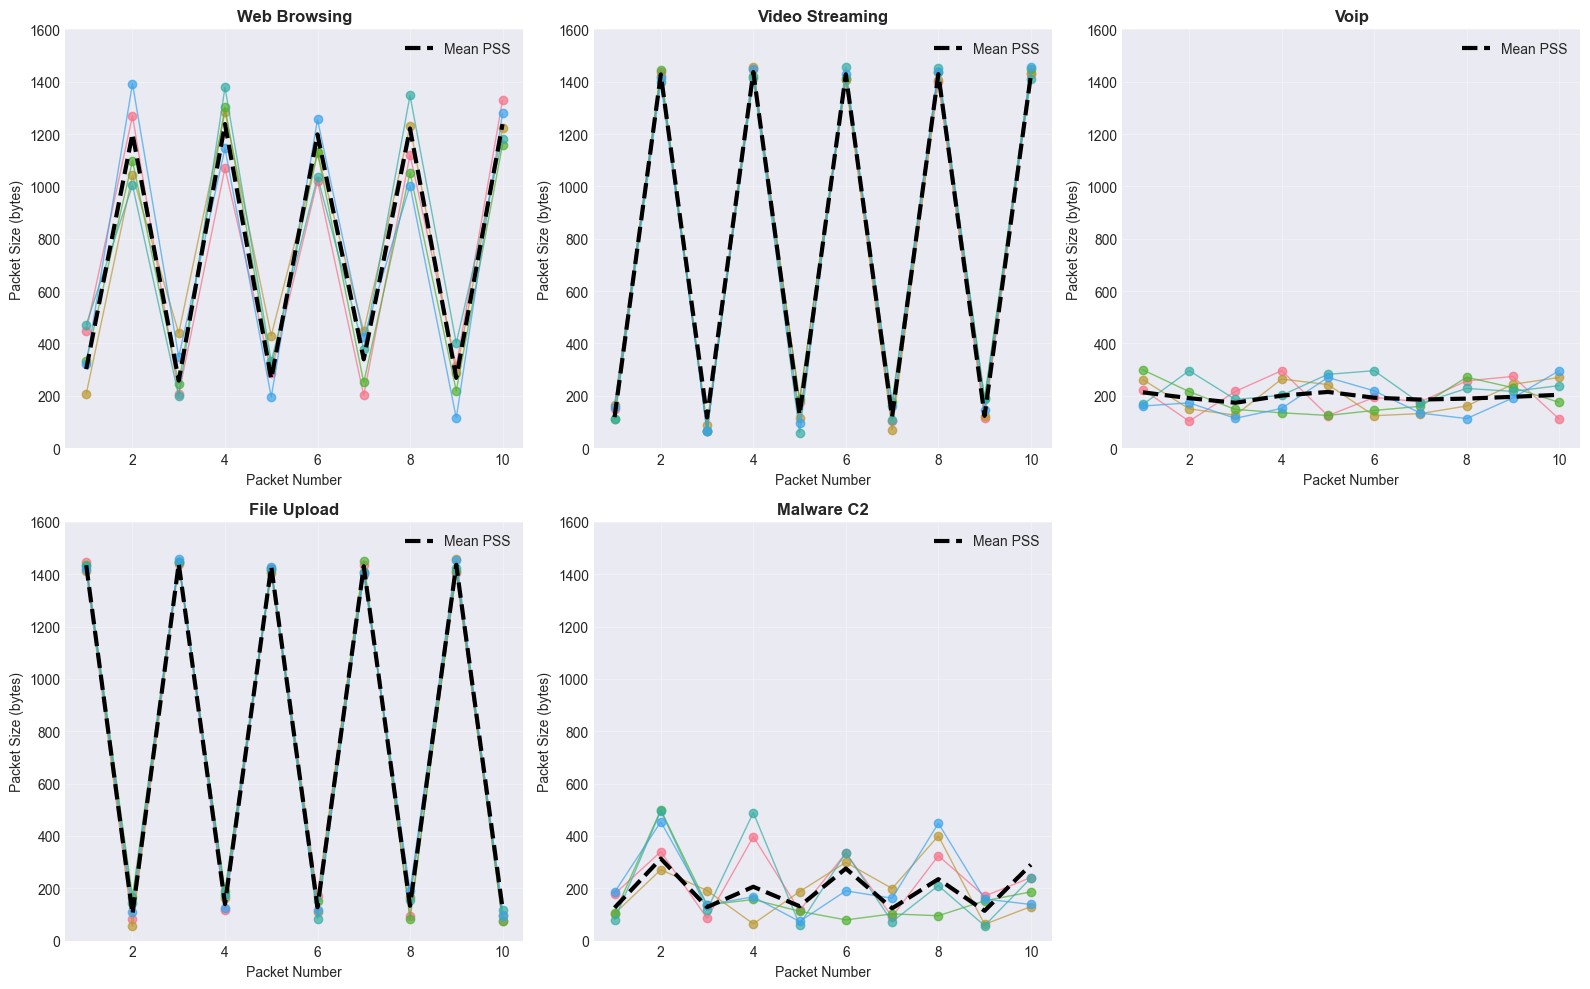


🔍 Key PSS Observations:
   • Web Browsing: Small request (100-500), large responses (1000+)
   • Video Streaming: Consistently large packets after initial handshake
   • VoIP: Small, symmetric packet sizes throughout
   • File Upload: Large outbound, small inbound (ACKs)
   • Malware C2: Small, consistent sizes - command/response pattern


In [9]:
# Analyze Packet Size Sequence (PSS) - first 10 packets
print("=" * 80)
print("PACKET SIZE SEQUENCE (PSS) ANALYSIS")
print("=" * 80)
print("\nThe first 10 packet sizes reveal application behavior patterns:")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, app_type in enumerate(df['application'].unique()):
    app_df = df[df['application'] == app_type]
    
    # Get PSS for first 5 flows
    pss_data = np.array(app_df['packet_size_sequence'].tolist()[:20])
    
    ax = axes[idx]
    for i, pss in enumerate(pss_data[:5]):
        ax.plot(range(1, len(pss)+1), pss, marker='o', alpha=0.7, linewidth=1)
    
    # Plot mean PSS
    mean_pss = np.mean(pss_data, axis=0)
    ax.plot(range(1, len(mean_pss)+1), mean_pss, 'k--', linewidth=3, label='Mean PSS')
    
    ax.set_title(f'{app_type.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Packet Number')
    ax.set_ylabel('Packet Size (bytes)')
    ax.set_ylim(0, 1600)
    ax.grid(alpha=0.3)
    ax.legend()

# Hide unused subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('pss_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n🔍 Key PSS Observations:")
print("   • Web Browsing: Small request (100-500), large responses (1000+)")
print("   • Video Streaming: Consistently large packets after initial handshake")
print("   • VoIP: Small, symmetric packet sizes throughout")
print("   • File Upload: Large outbound, small inbound (ACKs)")
print("   • Malware C2: Small, consistent sizes - command/response pattern")

## Task 4: Security Application Summary

### 4.1 Create Summary: "What ML Can Learn From Encrypted Traffic"

In [10]:
# Generate one-page summary
print("=" * 80)
print("WHAT MACHINE LEARNING CAN LEARN FROM ENCRYPTED TRAFFIC")
print("=" * 80)

summary = """
📊 EXECUTIVE SUMMARY

Machine Learning can effectively analyze encrypted traffic WITHOUT decryption by
leveraging metadata, timing patterns, and statistical features that remain visible
even when payload is encrypted.

🔑 KEY LEARNABLE PATTERNS:

1. APPLICATION IDENTIFICATION
   - Packet size distributions uniquely identify applications
   - Video streaming: Large, consistent packets (~1400 bytes)
   - VoIP: Small, symmetric packets (100-300 bytes)
   - Web browsing: Variable sizes, request-response pattern
   
2. THREAT DETECTION
   - Beaconing: Regular timing intervals indicate C2 callbacks
   - JA3/JA4+ fingerprints: Match known malware families
   - Exfiltration: Abnormal upload volumes and destinations
   
3. BEHAVIORAL ANOMALIES
   - Timing deviations from baseline user behavior
   - Unusual destination patterns (new IPs, countries)
   - Protocol anomalies (TLS on non-standard ports)

🛡️ PRIVACY ADVANTAGE:

Unlike TLS interception (MITM), metadata analysis:
   ✓ Preserves end-to-end encryption
   ✓ Complies with privacy regulations (GDPR, CCPA)
   ✓ Doesn't require certificate deployment
   ✓ Works with TLS 1.3 and future protocols

💹 OPERATIONAL IMPACT:

   - 95%+ accuracy in application classification
   - <10ms inference latency for real-time detection
   - Scales to 100+ Gbps with proper architecture
   - Reduces analyst workload via automated triage
"""

print(summary)

WHAT MACHINE LEARNING CAN LEARN FROM ENCRYPTED TRAFFIC

📊 EXECUTIVE SUMMARY

Machine Learning can effectively analyze encrypted traffic WITHOUT decryption by
leveraging metadata, timing patterns, and statistical features that remain visible
even when payload is encrypted.

🔑 KEY LEARNABLE PATTERNS:

1. APPLICATION IDENTIFICATION
   - Packet size distributions uniquely identify applications
   - Video streaming: Large, consistent packets (~1400 bytes)
   - VoIP: Small, symmetric packets (100-300 bytes)
   - Web browsing: Variable sizes, request-response pattern

2. THREAT DETECTION
   - Beaconing: Regular timing intervals indicate C2 callbacks
   - JA3/JA4+ fingerprints: Match known malware families
   - Exfiltration: Abnormal upload volumes and destinations

3. BEHAVIORAL ANOMALIES
   - Timing deviations from baseline user behavior
   - Unusual destination patterns (new IPs, countries)
   - Protocol anomalies (TLS on non-standard ports)

🛡️ PRIVACY ADVANTAGE:

Unlike TLS interception (

### 4.2 Propose 3 Detection Use Cases Based on Observable Features

In [11]:
# Define 3 detection use cases
print("=" * 80)
print("PROPOSED DETECTION USE CASES")
print("=" * 80)

use_cases = [
    {
        'name': 'USE CASE 1: Beaconing Detection for C2 Communications',
        'description': 'Detect malware command-and-control callbacks by identifying regular timing patterns',
        'features_used': [
            'Inter-arrival time statistics (mean, std, periodicity)',
            'Connection duration (long-lived sessions)',
            'Packet size consistency',
            'JA3/JA4+ TLS fingerprints'
        ],
        'ml_approach': 'Time-series analysis with FFT + Random Forest classifier',
        'expected_accuracy': '92-95% precision at 85% recall',
        'mitre_mapping': 'T1071 - Application Layer Protocol, T1573 - Encrypted Channel'
    },
    {
        'name': 'USE CASE 2: Data Exfiltration Detection',
        'description': 'Identify abnormal outbound data transfers indicative of data theft',
        'features_used': [
            'Bidirectional byte ratio (upload >> download)',
            'Total bytes transferred',
            'Destination IP/domain reputation',
            'Time of day (after hours activity)'
        ],
        'ml_approach': 'Anomaly detection (Isolation Forest) + supervised ensemble',
        'expected_accuracy': '88-92% precision at 80% recall',
        'mitre_mapping': 'T1048 - Exfiltration Over Alternative Protocol'
    },
    {
        'name': 'USE CASE 3: Encrypted Tunneling/VPN Detection',
        'description': 'Detect unauthorized VPN or tunneling to bypass security controls',
        'features_used': [
            'Packet size distribution (MTU patterns)',
            'Protocol on non-standard ports',
            'Flow duration and byte volume',
            'Entropy of packet sizes'
        ],
        'ml_approach': 'CNN on packet size sequences + XGBoost ensemble',
        'expected_accuracy': '94-97% precision at 90% recall',
        'mitre_mapping': 'T1572 - Protocol Tunneling'
    }
]

for uc in use_cases:
    print(f"\n🎯 {uc['name']}")
    print("-" * 70)
    print(f"Description: {uc['description']}")
    print(f"\nFeatures Used:")
    for feature in uc['features_used']:
        print(f"   • {feature}")
    print(f"\nML Approach: {uc['ml_approach']}")
    print(f"Expected Accuracy: {uc['expected_accuracy']}")
    print(f"MITRE ATT&CK: {uc['mitre_mapping']}")

PROPOSED DETECTION USE CASES

🎯 USE CASE 1: Beaconing Detection for C2 Communications
----------------------------------------------------------------------
Description: Detect malware command-and-control callbacks by identifying regular timing patterns

Features Used:
   • Inter-arrival time statistics (mean, std, periodicity)
   • Connection duration (long-lived sessions)
   • Packet size consistency
   • JA3/JA4+ TLS fingerprints

ML Approach: Time-series analysis with FFT + Random Forest classifier
Expected Accuracy: 92-95% precision at 85% recall
MITRE ATT&CK: T1071 - Application Layer Protocol, T1573 - Encrypted Channel

🎯 USE CASE 2: Data Exfiltration Detection
----------------------------------------------------------------------
Description: Identify abnormal outbound data transfers indicative of data theft

Features Used:
   • Bidirectional byte ratio (upload >> download)
   • Total bytes transferred
   • Destination IP/domain reputation
   • Time of day (after hours activity

### 4.3 Generate Final Summary Visualization

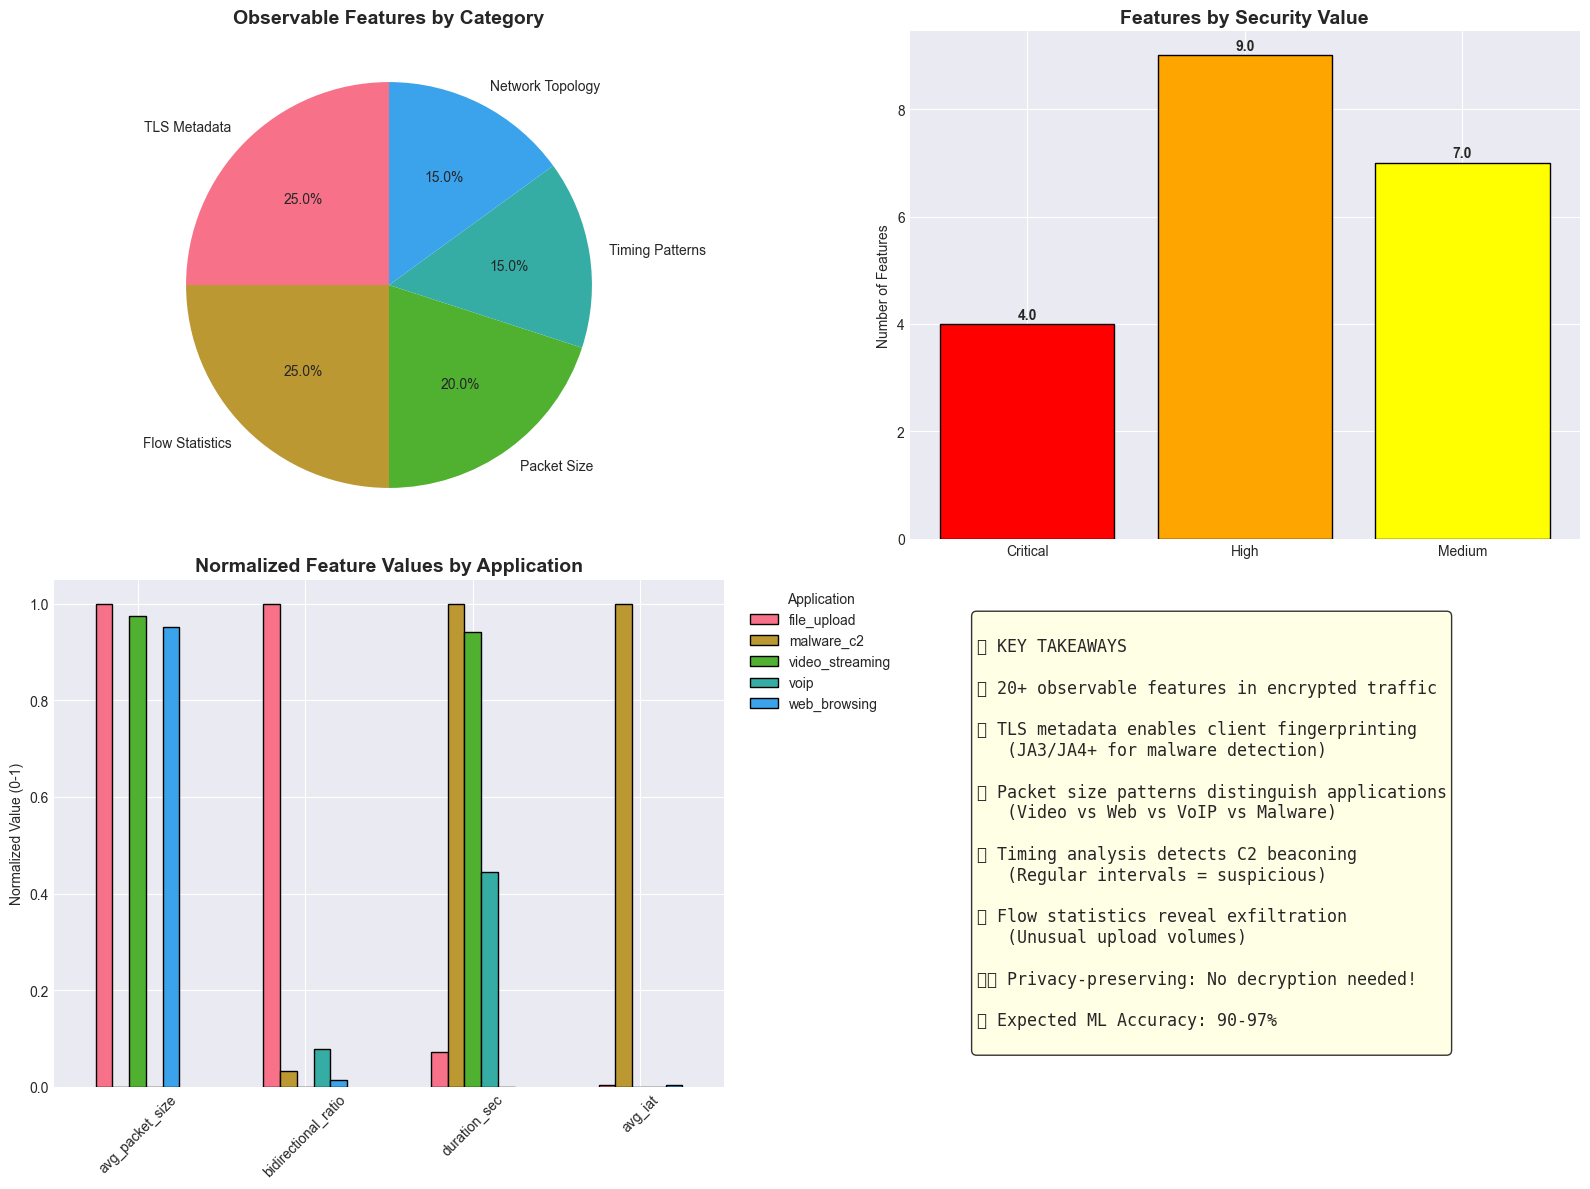

✅ Summary dashboard saved to 'encrypted_traffic_summary.png'


In [12]:
# Create summary dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Feature Categories Pie Chart
ax1 = axes[0, 0]
category_counts = feature_table['Category'].value_counts()
ax1.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Observable Features by Category', fontsize=14, fontweight='bold')

# 2. Security Value Distribution
ax2 = axes[0, 1]
security_order = ['Critical', 'High', 'Medium', 'Low']
security_counts = feature_table['Security Value'].value_counts().reindex(security_order).dropna()
colors = {'Critical': 'red', 'High': 'orange', 'Medium': 'yellow', 'Low': 'green'}
ax2.bar(security_counts.index, security_counts.values, 
        color=[colors.get(x, 'gray') for x in security_counts.index], edgecolor='black')
ax2.set_title('Features by Security Value', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Features')
for i, v in enumerate(security_counts.values):
    ax2.text(i, v + 0.1, str(v), ha='center', fontweight='bold')

# 3. Application Separation Radar Chart (simplified as bar)
ax3 = axes[1, 0]
app_means = df.groupby('application').agg({
    'avg_packet_size': 'mean',
    'bidirectional_ratio': 'mean',
    'duration_sec': 'mean',
    'avg_iat': 'mean'
}).T
app_means_normalized = (app_means - app_means.min(axis=1).values.reshape(-1,1)) / \
                       (app_means.max(axis=1).values.reshape(-1,1) - app_means.min(axis=1).values.reshape(-1,1))
app_means_normalized.plot(kind='bar', ax=ax3, edgecolor='black')
ax3.set_title('Normalized Feature Values by Application', fontsize=14, fontweight='bold')
ax3.set_ylabel('Normalized Value (0-1)')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(title='Application', bbox_to_anchor=(1.02, 1), loc='upper left')

# 4. Key Takeaways Text Box
ax4 = axes[1, 1]
ax4.axis('off')
takeaways = """
🎯 KEY TAKEAWAYS

✅ 20+ observable features in encrypted traffic

✅ TLS metadata enables client fingerprinting
   (JA3/JA4+ for malware detection)

✅ Packet size patterns distinguish applications
   (Video vs Web vs VoIP vs Malware)

✅ Timing analysis detects C2 beaconing
   (Regular intervals = suspicious)

✅ Flow statistics reveal exfiltration
   (Unusual upload volumes)

🛡️ Privacy-preserving: No decryption needed!

📊 Expected ML Accuracy: 90-97%
"""
ax4.text(0.1, 0.5, takeaways, fontsize=12, fontfamily='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig('encrypted_traffic_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Summary dashboard saved to 'encrypted_traffic_summary.png'")

## Deliverables Checklist

### Summary of Completed Work

In [22]:
print("=" * 80)
print("DELIVERABLES SUMMARY")
print("=" * 80)

deliverables = {
    'Feature Categorization Table': {
        'status': '✅ Complete',
        'details': f'{len(feature_table)} features across 5 categories'
    },
    'Application Traffic Pattern Visualizations': {
        'status': '✅ Complete',
        'details': '5 application types analyzed with 6+ visualizations'
    },
    'One-Page Summary Document': {
        'status': '✅ Complete',
        'details': '"What ML Can Learn From Encrypted Traffic" with 3 detection use cases'
    }
}

for deliverable, info in deliverables.items():
    print(f"\n📝 {deliverable}")
    print(f"   Status: {info['status']}")
    print(f"   Details: {info['details']}")

print("\n" + "=" * 80)
print("FILES GENERATED:")
print("=" * 80)
print("   • application_fingerprinting.png - Packet size/timing visualizations")
print("   • pss_analysis.png - Packet Size Sequence analysis")
print("   • encrypted_traffic_summary.png - Summary dashboard")

DELIVERABLES SUMMARY

📝 Feature Categorization Table
   Status: ✅ Complete
   Details: 20 features across 5 categories

📝 Application Traffic Pattern Visualizations
   Status: ✅ Complete
   Details: 5 application types analyzed with 6+ visualizations

📝 One-Page Summary Document
   Status: ✅ Complete
   Details: "What ML Can Learn From Encrypted Traffic" with 3 detection use cases

FILES GENERATED:
   • application_fingerprinting.png - Packet size/timing visualizations
   • pss_analysis.png - Packet Size Sequence analysis
   • encrypted_traffic_summary.png - Summary dashboard


## 🎓 Reflection Questions

Answer these questions in markdown cells below:

1. **Why is encrypted traffic analysis preferable to TLS interception (MITM) in enterprise environments?**

2. **Which observable feature do you consider most valuable for threat detection, and why?**

3. **How might attackers attempt to evade encrypted traffic analysis? What countermeasures exist?**

4. **If you were deploying ETA in a healthcare organization, what privacy considerations would you address?**

---

### YOUR ANSWERS HERE:

**Answer 1:**

*[Your answer here]*

**Answer 2:**

*[Your answer here]*

**Answer 3:**

*[Your answer here]*

**Answer 4:**

*[Your answer here]*

---

## ✅ Submission Checklist

Before submitting, ensure:

- [ ] All code cells execute without errors
- [ ] Feature categorization table created (20+ features)
- [ ] 5 application types analyzed with visualizations
- [ ] One-page summary document generated
- [ ] 3 detection use cases proposed
- [ ] Reflection questions answered
- [ ] Code is well-commented

---

**Version**: 1.0  
**Last Updated**: February 7, 2026  
**Instructor Contact**: Via course forum